# Measurement Error Models using PyMC3

*By Herman Carstens*

# Introduction and  Motivation

In this notebook, we'll investigate the effect of measurement error on statistical inference, and how this affects energy monitoring. Acknowledgement goes to Jake van der Plas for [a blog post](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/) using a similar example, as well as Thomas Wiecki (one of the PyMC3 devs) for [his blog post](https://pymc-devs.github.io/pymc3/GLM-linear/). Abraham Flaxman also answered [this](http://stackoverflow.com/questions/24804298/fit-a-non-linear-function-to-data-obs-with-pymcmc-pymc) StackOverflow question with a [notebook](http://nbviewer.ipython.org/gist/aflaxman/d4b1ce53b0817a1b7a71) that helped tremendously.

Almost all measurements have some error associated with it. While we can ignore this error in certain instances, sometimes it may be significant enough for us to have to account for it. In this notebook we will explore how measurement errors affect regression parameter estimates, and how this can be mitigated using Bayesian statistics.

First, some Python preliminaries to import the necessary libraries and tweak the notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import scipy
import scipy.stats

%matplotlib inline
seaborn.set

from pylab import rcParams
rcParams['figure.figsize']=18,8 #figure sizes

/home/herman/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## The effect of measurement error on regression estimates

To demonstrate the effect of measurement error on a regression model, we will generate some data with known characteristics, add errors to it, and see how this error affects the paramater estimates.

### Error in Y

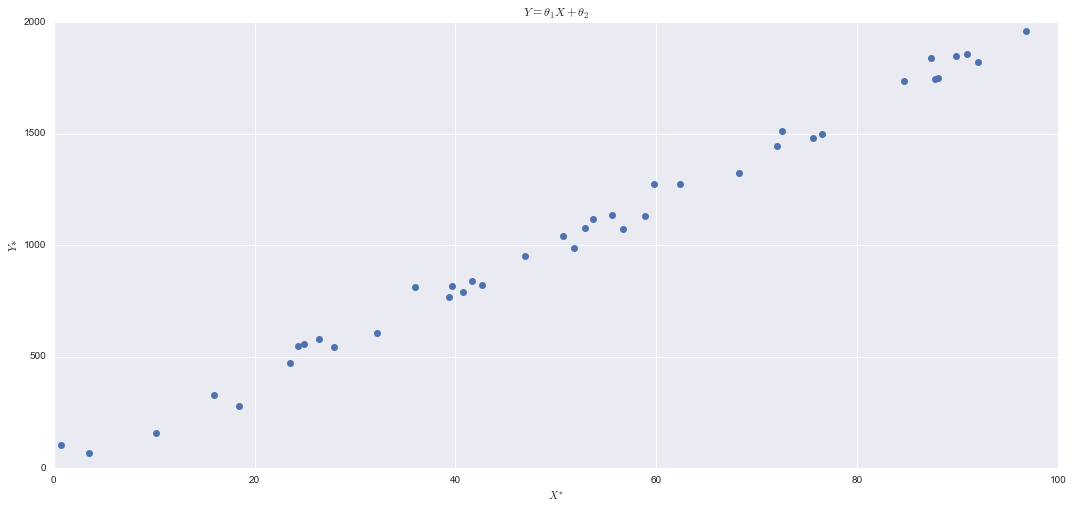

In [2]:
theta=(1,20)

x_data=100*np.random.random(40)
y_data=theta[0]+theta[1]*x_data

y_star=np.random.normal(y_data,40)
x_star=np.random.normal(x_data,1)

plt.plot (x_star, y_star,'o')
plt.title(r"$Y=\theta_{1}X+\theta_{2}$")
plt.xlabel(r'$X^{*}$')
plt.ylabel(r'$Y{*}$')

The error doesn't have a big impact on how the data is scattered. We can still draw a reasonable straight line through it. Now let's add a measurement error in the independent variable $X$:

### Error in X

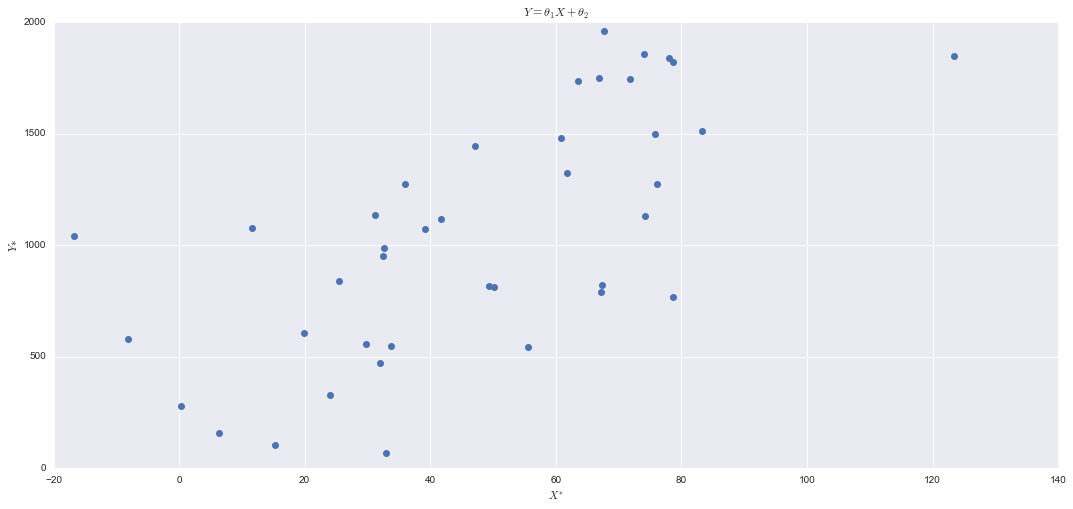

In [3]:
x_star=np.random.normal(x_data,20)

plt.plot (x_star, y_star,'o')
plt.title(r"$Y=\theta_{1}X+\theta_{2}$")
plt.xlabel(r'$X^{*}$')
plt.ylabel(r'$Y{*}$')

Clearly, this is much worse. However, the scatter does not only add uncertainty, but actually *changes* the parameter estimates, by biasing the slope towards zero. In the graph above, notice how it is a 'flattened out' version of first one: the y-axis values are the same, but the x-axis' maximum value has stretched form 100 to 120. To illustrate the effect on parameter estimates, let's do Ordinary Least Squares regression on the data above:

Erroneous Regression parameters:  12.5 457.3
True Regression parameters:        1     20


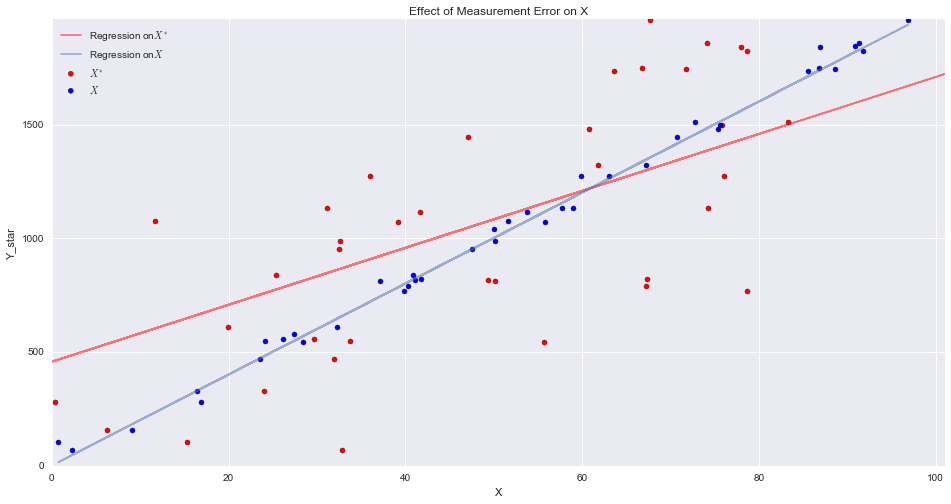

In [4]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, xlabel='X', ylabel='Y_star', 
                     title='Effect of Measurement Error on X', 
                     xlim=(0, np.int(x_data.max())+5), ylim=(0,np.int(y_star.max())+5))

ax.scatter(x_star,y_star,c='r',s=26, label = r'$X^{*}$')
ax.scatter(x_data,y_star,s=26, label = r'$X$')

#LS Function
def LSfit_straight(params):
    [a,b]=[params[0], params[1]]
    return np.sum((y_star-(a*x_star+b))**2)


res = scipy.optimize.minimize(LSfit_straight,np.array([1, 1]), method='Nelder-Mead')
res.message

ax.plot(x_star,res.x[0]*x_star+res.x[1],c='r',alpha=0.5,label='Regression on' r'$X^{*}$')
ax.plot(x_data,y_data,alpha=0.5,label='Regression on' r'$X$')
ax.legend(loc='upper left');
print('Erroneous Regression parameters: ' , "{:.1f}".format(res.x[0]),"{:.1f}".format(res.x[1]))
print('True Regression parameters:       ' , 1,'   ',20)

As we expected, the linear regression estimates are far from our specified `(20,20)`. This is called attenuation, and is a problem specifically when we measure our independent variable with error.

## Attenuation

Errors in measuring $Y$ does increase uncertainty in $Y$ as the error increases, but do not bias parameter estimates. Below we plot the parameter estimates of the regression model above, versus the size of the error.

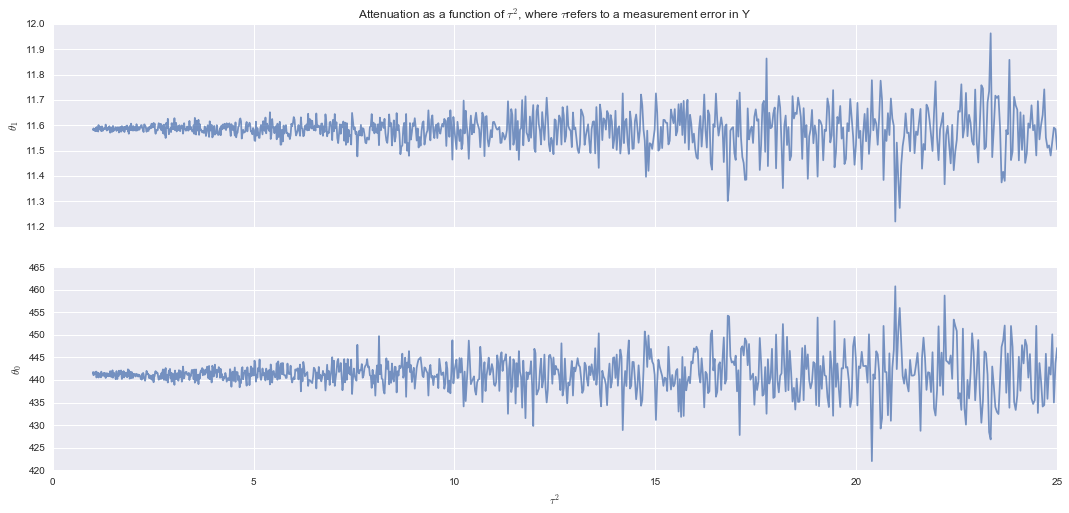

In [5]:
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
x_star=np.random.normal(x_data,20) #reset x_star value
    
k=0
tau=np.linspace(1,5,1000)
theta_star=np.zeros([2,len(tau)])
for i in range(len(tau)):
    y_star=np.random.normal(y_data,tau[i]**2)
    y,x=dmatrices('y_star~x_star',return_type='dataframe')
    est=LinearRegression()
    est.fit(x,y)
    theta_star[1,k]=est.coef_[0][1]
    theta_star[0,k]=est.intercept_[0]
    k=k+1
    
y_star=np.random.normal(y_data,20) #reset y_star

    
f,axarr=plt.subplots(2,sharex=True)
axarr[0].plot(tau**2,theta_star[1,:],alpha=0.75)
axarr[0].set_title('Attenuation as a function of ' r'$\tau^{2}$, where ' r'$\tau$'
                   'refers to a measurement error in Y')
axarr[1].set_xlabel(r'$\tau^{2}$')
axarr[0].set_ylabel(r'$\theta_{1}$')
axarr[1].plot(tau**2,theta_star[0,:],alpha=0.75)
axarr[1].set_ylabel(r'$\theta_{0}$')

We can see that as the error increases, our uncertainty about the parameter estimates increase. However, the mean parameter estimate remains unbiased.

This is not the case when an error is added to $X$. Not only does uncertainty increase, but the estimate becomes *biased*. This is called attenuation, which we can see in the plot below, as shown in [Gustafson](https://www.crcpress.com/Measurement-Error-and-Misclassification-in-Statistics-and-Epidemiology/Gustafson/9781584883357). Attenuation is when the estimate on the slope parameter in a linear regression model is reduced because of error in the measurement of the independent variable $X$. The attenuation factor can be defined as:

$\frac{\theta_{1}^{*}}{\theta_{1}}=\frac{1}{1+\tau^{2}}$,

where $\tau^{2}$ is the error term such that $(X^{*}\mid X,Y)\sim N(X,\tau^{2}\sigma^{2})$ 

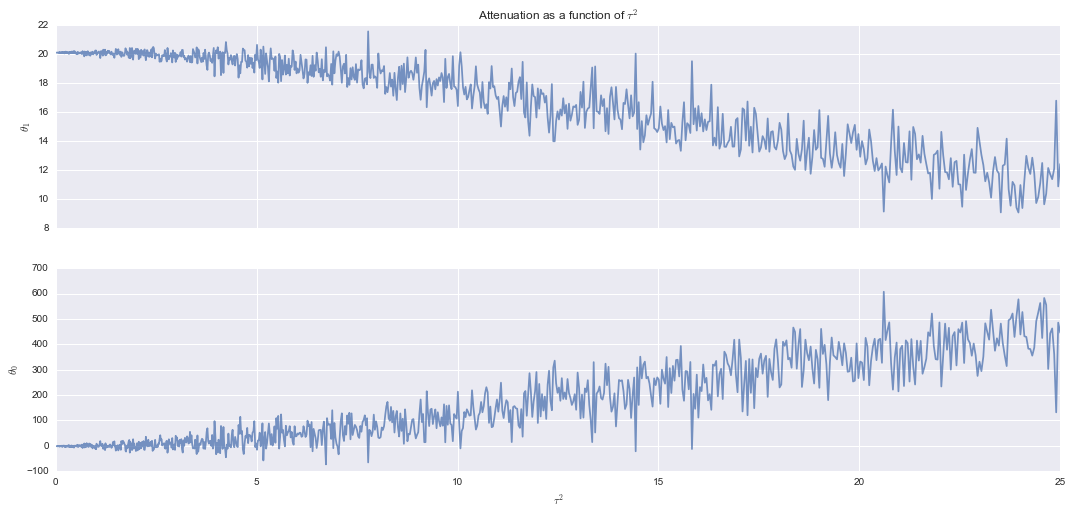

In [6]:
k = 0
tau = np.linspace(0.001, 5, 1000)
theta_star = np.zeros([2, len(tau)])
for i in range(len(tau)):
    x_star = np.random.normal(x_data, tau[i]**2)
    y, x = dmatrices('y_star~x_star', return_type='dataframe')
    est = LinearRegression()
    est.fit(x, y)
    theta_star[1, k] = est.coef_[0][1]
    theta_star[0, k] = est.intercept_[0]
    k=k+1
    
f,axarr = plt.subplots(2, sharex=True)
axarr[0].plot(tau**2, theta_star[1, :], alpha=0.75)
axarr[0].set_title('Attenuation as a function of ' r'$\tau^{2}$')
axarr[1].set_xlabel(r'$\tau^{2}$')
axarr[0].set_ylabel(r'$\theta_{1}$')
axarr[1].plot(tau**2,theta_star[0,:], alpha=0.75)
axarr[1].set_ylabel(r'$\theta_{0}$')

From the graph above it is clear that as $\tau^{2}$ increases, the estimate for $\theta_{1}$ decreases. As a result of this, the estimate for the y-intercept $\theta_{0}$ increases.

# A Potential Solution

In the real world, we have no access to the true parameters - all we have are the noisy $X^{*}$ and $Y^{*}$ measurements. And so we may know that our parameter estimates are biased, but we don't know by how much. In more complex regression cases, we wouldn't even know in which direction this bias manifests.

Regression on errors-in-measurements data has been a particularly difficult problem to solve in frequentist statistics, as shown by [Jaynes](http://exordio.qfb.umich.mx/archivos%20pdf%20de%20trabajo%20umsnh/aphilosofia/bayesian%20importantes/leapz.pdf). [Carrol et al.](http://www.stat.tamu.edu/~carroll/eiv.SecondEdition/) have written an excellent textbook on modern frequentist methods, and [Gustafson](https://www.crcpress.com/Measurement-Error-and-Misclassification-in-Statistics-and-Epidemiology/Gustafson/9781584883357) gives a good appraisal of these methods. The approach adopted below relies on Bayes Markov Chain Monte Carlo (MCMC) implemented via PyMC3.

A brief note on frequentist vs. Bayesian regression. In frequentist regression, we see write the linear regression equation as:

$Y=X\theta+\epsilon$,

whereas in a Baysian framework, we acknowledge the uncertainty in $Y$ by writing the regression equation as

$Y \backsim N(X\theta,\sigma^{2})$.

# Application

<img src="energy_logger.jpg", style="width: 300px">


Suppose that we want to calibrate an electrical energy meter using a power supply or second energy meter with a known error. Let $X$ be the true values, $X^{*}$ be the values measured by the calibrator, and $Y^{*}$ be the values measured by the Unit Under Test (UUT). So both the UUT and calibrator receive $X$ as an input, but this is changed to, and displayed as $X^{*}$ and $Y^{*}$ according to their internal errors.

If we simply regress $Y^{*}$ against $X^{*}$, pretending that there are no errors in the independent variable, i.e. $X^{*}=X$, then the $Y^{*}$ parameters will be attenuated with respect to $X$. This is called naïve estimation, and the calibration will be biased. We want to get as close to $Y$ as possible, and so we have to take the error of $X^{*}$ into consideration in the mathematics.

We should note here that identifying these errors in electrical measurements has certain challenges. First, instruments are generally very accurate, and so the errors may be small. Second, methods such as those proposed by Gustafson are not applicable for the experiment at hand: if we could do gold-standard measurements, we would use the gold standard as a calibrator, and not be concerned with errors in $X$. Of course, this is different for medical studies where it may only be practical to do comprehensive, gold-standard testing on a few patients. On the other hand, we can specify well-known structural models for electrical measurements that would not be available in medical studies. It is this strength that we will exploit below.

## Calibrator Error

Energy meter accuracy is usually specified by their 'Class' designation, as a precision value: $p = 0.5\%, 1\%, 2\%$, etc. This refers to the $95\%$ confidence interval limit: it may be at $1.005\mu, 1.01\mu, 1.2\mu$, etc. Notice that this is then a multiplicative error: $X^{*} = X(1+p)$, where $p$ is the precision value. We are going to assume that this is the only information we have about $X^{*}$.


## UUT Error

For the UUT we can specify a more detailed model, as presented by [Carobbi et al.](http://www.imeko2009.it.pt/Papers/FP_405.pdf):

$Y^{*} = (1+\alpha)Xcos(\phi+\phi_{c})+\epsilon$,

where $\alpha$ is the gain error, $\phi_{c}$ the phase error, and $\epsilon$ the bias error. As mentioned above, though, when we do the regression, we only have access to $X^{*}$. We actually only have

$Y^{*} = (1+\alpha)X^{*}cos(\phi+\phi_{c})+\epsilon$,

Which attenuates as shown above.

### Small digression: Multiplicative errors and frequentist analysis
It is worth noting at this point that the error in the calibrator is multiplicative, not additive. This means that the data are [*heteroscedastic*](https://en.wikipedia.org/wiki/Heteroscedasticity): the variance around each data point is a function of its value: the larger the value, the larger the variance. In frequentist regression analysis, this is where the wheels come off. We need constant variance on the data for the maths to work. In order keep using standard frequentist regression techniques, you have to regress against $logX^{*}$ (So that you get $logX^{*} = logX + log\epsilon$ and are back in additive mode), and then work with lognormal distributions, etc. It can be done for some cases, but it is by no means pretty. A far more elegant solution, to my mind, is using a Bayesian statistical model, as will be demonstrated below.

## Modelling the calibration

We now have the mathematical framework with which to model the calibration process and can move on to modelling this in software. I'm using `PyMC3`, an open-source Bayesian library implemented in `Python`.

First, we need to define the parameters with which we will generate the synthetic data set. We need to use a synthetic data set rather than a real one so that we have access to the true values, not only the erroneous ones. I have specified a $20\%$ error on the gain, and a $0.2$ radian ($11.46^{\text{o}})$ error on the phase. To make things slightly more interesting, I have allowed $\epsilon$ to be normally distributed, rather than have a constant value. But it has a mean of 5.

In [7]:
# Preliminaries
from pymc3 import *
import theano.tensor as T
theano.config.exception_verbosity = 'high' # for handling theano errors more accurately

# Parameter definitions
GAIN_ERROR = 0.2
PHASE_ERROR = 0.2
BIAS_ERROR_MEAN = 5
BIAS_ERROR_SD = BIAS_ERROR_MEAN*0.5
X_PRECISION = 0.1 # precision of calibrator at 95% confidence level
X_CONF = 1.96 # z = 1.96 is the 95% confidence level.

To simplify some code later on, I define a function to take care of converting the true input of the UUT, $X$, to the output $Y^{*}$:

In [8]:
def x_to_y_star(x, yg, yp, ybm, ybsd, phi):
    # generate individual bias errors for every point of x, according to the
    # normal distribution with parameters ybm and ybsd
    return ((1 + yg)*x*np.cos(yp+phi) + np.random.normal(loc=ybm, scale=ybsd, size=x.size))

Next, we generate the data. Note that the experiment measures values between zero and a hundred, repeated at three levels of the [Power Factor](https://en.wikipedia.org/wiki/Power_factor) (PF). I have worked in radians (i.e., specifying $\phi$), and not PF itself, where $PF=cos\phi$. The experiment is this repeated for $\phi = \{\frac{\pi}{3},\frac{\pi}{6},0\}$. Not only does this simplify the code, but it is also the preferable way to specificy non-informative priors later on, as shown by [van der Plas](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/).

In [9]:
testpoints = pd.Series(np.arange(5, 105, 5))  #Testpoints are the points at which readings are taken, i.e. where
                                                #the calibrator is set to 5, 10, 15...
phipoints_ones = pd.Series(np.ones_like(testpoints))
x_star_arr = pd.concat([testpoints, testpoints, testpoints],
                       ignore_index=True)

x_err = np.random.normal(1, X_PRECISION/X_CONF, size=x_star_arr.size)
# Since the distribution is symmetric, the error term can by multiplied into 
# x or x_star
x = x_star_arr*x_err
phi_v = pd.concat([np.pi/3*phipoints_ones, np.pi/6*phipoints_ones, 0*phipoints_ones], ignore_index=True)
y_star = x_to_y_star(x, GAIN_ERROR, PHASE_ERROR, BIAS_ERROR_MEAN, BIAS_ERROR_SD, phi_v)

obs = pd.DataFrame({'x_star':x_star_arr, 'phi':phi_v, 'y_star':y_star, 'x':x})

## Model Selection

From the definitions above, we know that the true parameters with which the data were generated, are:

$\alpha = 0.2$

$\phi_{c} = 0.2$

$\epsilon = 5$.

A good model would be one that eliminates us much bias as possible, and thus estimates the parameters as closely as possible. Second, a good model should fit the data well on a graph. This is not always the same thing, as one paramater estmiate may be 'high' and another 'low', but the fit on the graph still acceptable.

Since it is possible for the randomly generated data to bias the parameters, $(\alpha, \phi_{c}, \epsilon \mid Data)$ should also be determined. i.e., the true parameters given this random data set. A simple, accurate way to establish this baseline is to minimise the absolute error, for a minimum absolute error (MAE) fit. The absolute error is preferred over the least squares error because it places less weight on the higher values, which happen to have higher variance in our case because our errors are multiplicative. In order to reduce the attenuation affect (large variance on larger values) even more, errors are divided by their corresponding $X$ value, yielding a Weighted Minimum Absolute Error (WMAE):

$WMAE = \text{min}\Sigma_{i=1}^{n} \frac{\mid Y^{*}_{i}-(1+\alpha)X_{i}cos(\phi+\phi_{c})+\epsilon)\mid}{X_{i}}$

Four models have been selected for comparison:

1. A naïve WMAE model, as described above, but where $X^{*}$ instead of $X$ is used.
2. A Bayesian model with a Normal priors on $X$, the parameters, and the likelihood function of $Y^{*}$
3. A naïve Bayesian model using $X^{*}$ and normal priors for the parameters and likelihood function of $Y^{*}$

For cases 2. and 3., the WMAE estimates are used as a starting point for the MCMC algorithm and for specifying the priors.  This function is defined as:

In [10]:
#Function for sum(|y*-y*(X*)| / X*)
def Abs_error_x_star(params):
    [yg,yp,yb]=[params[0], params[1], params[2]]
#    y_hat=(1 + yg)*obs.x_star*np.cos(yp+obs.phi) + yb
#    return np.sqrt(np.sum((obs.y_star-y_hat)**2)/obs.y_star.size)/obs.y_star.mean(axis=0)*100
    return np.sum((np.abs(obs.y_star-((1 + yg)*obs.x_star*np.cos(yp+obs.phi) + yb)))
                  /(obs.x_star))

## 1. Minimum Absolute Error Estimation

First, we find the reference solution using $X$, which at our disposal in the real world:

In [11]:
def Abs_error_x(params):
    [yg,yp,yb]=[params[0], params[1], params[2]]
    #y_hat=(1 + yg)*obs.x*np.cos(yp+obs.phi) + yb
    #return np.sqrt(np.sum((obs.y_star-y_hat)**2)/obs.y_star.size)/obs.y_star.mean(axis=0)*100
    return np.sum(np.abs((obs.y_star-((1 + yg)*obs.x*np.cos(yp+obs.phi) + yb)))/obs.x_star)

res2 = scipy.optimize.minimize(Abs_error_x, np.array([0.0, 0.0, 0.0]), method='Powell')
res2.message

'Optimization terminated successfully.'

Then we run the same optimisation, but with $X^{*}$:

In [12]:
res = scipy.optimize.minimize(Abs_error_x_star, np.array([0.0, 0.0, 0.0]),method='Powell')
res.message

'Optimization terminated successfully.'

## 2. Full Bayesian Model

### Bayesian Model specification

In a Bayesian model we have to define priors. These are distributions which include the prior information we have about the process, excluding that which came from the data itself. In our case, we have some prior information about the gain, phase, and bias errors, as well as about the error in $X$.

#### Priors

For the gain and phase errors, Uniform priors between -1 and 1 would be good, but we do actually have some relevant information in the form of relatively accurate estimates from the WMAE. From experience with simulations not shown here we can be reasonably sure that the true value would be within $25\%$ of $\hat\alpha_{WMAE}$, we can specify the standard deviation as $0.25\hat\alpha_{WMAE}$.

$P(\alpha) \sim Normal(\mu=\hat\alpha_{WMAE},\  \sigma = 0.25\hat\alpha_{WMAE})$


The phase error should be similar to the gain error:


$P(\phi_{c}) \sim Normal(\mu=\hat\phi_{WMAE},\ \sigma = 0.25\hat\phi_{WMAE})$.


$P(\epsilon) \sim Normal(\mu = \hat\epsilon_{WMAE}, \sigma = 0.25\hat\epsilon_{WMAE})$.

We specify a prior on the calibrator error. We can safely assume a normal distribution according to the 10% precision at 95% confidence specification.

$P(p) \sim Normal\left(1,\frac{p}{conf. level}\right)\sim Normal\left(1,\frac{0.01}{1.96}\right)$

For model 3, the variance will not change as a function of $X$.

Now we can specify the prior on $X$. We know that $X^{*}=Xp$. We only have $X^{*}$ at our disposal, but we can divide this by the distribution $P(p)$ to get distributions around the $X^{*}$ data points indicating likely values of $X$. These distributions are heteroscedastic, as we need them to be, since we could specify this in our definition of $P(\epsilon)$. Therefore we can include into our prior belief that $\textrm{VAR}(X_{1}=1) >> \textrm{VAR}(X_{n}=100)$. Because we sample using an MCMC technique, the various combinations of $X$ values will be represented in proportion to their probabilities. The plot below illustrates how the algorithm models these variances:

<img src="x_prior_trace.png", style="width: 1000px">

Looking at it a different way, we know $P(X^{*}|X)$, and $P(X)$. The MCMC algorithm uses this, by Bayes' Theorem, to produce $P(X|X^{*})$ - a distribution we would not normally have access to, but which we do need if we want to avoid attentuation. All things considered, then:

$P(X) \sim Normal \left(\frac{X^{*}}{P(p)},P(p)\right)$


#### Likelihood

Since we are writing a probabilistic program, we replace the parameters with the prior distributions we just specified. In a standard regression where are points are weighted equally, the likelihood function would be:


$P(Y^{*}\rvert X^{*}) \sim StudentT\bigl(\mu=1+P(\alpha)) X^{*}cos\bigl( \phi+P(\phi_{c})\bigr) +P(\epsilon),\  \sigma=X\frac{p}{z^{2}}\bigr)$.

I should note that for a reason I don't understand, we obtain better results using $z^{2}$ than $z$. At the moment, this is ad hoc. The effect is to decrease the variance on $\hat{Y}$. Notice that this variance increases with the value of $X^{*}$. This is like a weighting function: for larger values of $X^{*}$, more variance in $Y^{*}$ is allowed.

We can now write the likelihood function for $Y$ as $P(Y\rvert X^{*},Y^{*})$, where we simply specify that it is a likelihood function by adding the term 

`observed=obs.y_star` to the parameters passed for `pymc3.Normal()`.

At this point I have wondered, why not specify the WMAE function as the likelihood for $\mu$, with `observed=0`? The answer, I think, is that doing this would be to use the MCMC as an optimisation algorithm, which it is not. The Powell (modified Simplex) algorithm used to find the WMAE estimates is much more efficient. The Bayesian approach is entirely different. First, we simulate $X^{*}\sim Normal(Xp,\sigma)$, so that the regressor vector in our MCMC runs approximates the distribution on $X^{*}$. The WMAE is simply weighting errors blindly. Second, the answers we obtain are not just point estimates, but distributions, given the data observed for $Y^{*}$.

#### MCMC

Since only continuous distributions were specified, the No U-Turn Sampler (NUTS) is used, with the Nelder-Mead WMAE parameter estimates used as the starting point for the priors. Since many variables are specified (specifically owing to the prior on $X$), a many samples are needed.

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '4733' (I am process '8431')


 [-----------------100%-----------------] 200000 of 200000 complete in 3303.1 sec

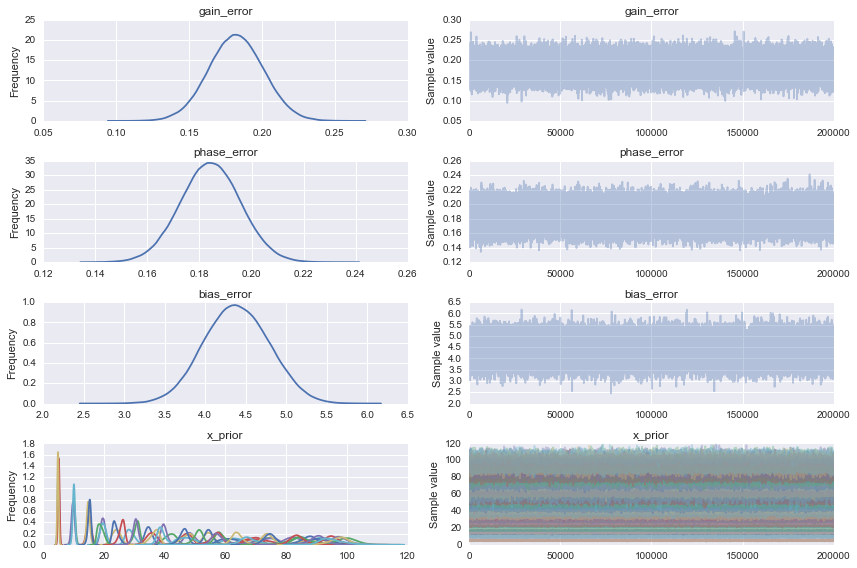

In [13]:
with Model(verbose=0) as model:
        
    # Definition of priors
        gain_error = Normal('gain_error', mu=res.x[0], sd=res.x[0]*0.25)
        phase_error = Normal('phase_error', mu=res.x[1], sd=res.x[1]*0.25)
        bias_error = Normal('bias_error', mu=res.x[2], sd=res.x[2]*0.25)
        sd_x = obs.x_star.as_matrix()*(X_PRECISION/(X_CONF))    
        sd_y = obs.y_star.as_matrix()*(X_PRECISION/(X_CONF**2))
        shape=obs.x_star.size
        mu_x = obs.x_star
        
        x_prior = Normal('x_prior',
                         mu=mu_x,
                         sd=sd_x,
                         shape=shape,
                         testval=obs.x_star)
                         
        mu_y = (1 + gain_error)*x_prior*T.cos(phase_error + obs.phi) + bias_error

    # Likelihood
        y_likelihood = StudentT('y_est',
                                nu=1,
                                mu=mu_y,
                                sd=sd_y,
                                shape=shape,
                                observed=obs.y_star)

        start = {'gain_error': res.x[0], 'phase_error': res.x[1], 'bias_error': res.x[2], 'x_prior': obs.x_star}
        trace = sample(200000, step=NUTS(), start=start)


hist = pd.DataFrame()
Bayes1=np.array([np.nan, np.nan, np.nan])
hist['index'] = pd.Series(np.histogram(trace.gain_error, bins=200)[1])
hist['count'] = pd.Series(np.histogram(trace.gain_error, bins=200)[0])
Bayes1[0] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]

hist['index'] = pd.Series(np.histogram(trace.phase_error, bins=200)[1])
hist['count'] = pd.Series(np.histogram(trace.phase_error, bins=200)[0])
Bayes1[1] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]

hist['index'] = pd.Series(np.histogram(trace.bias_error, bins=200)[1])
hist['count'] = pd.Series(np.histogram(trace.bias_error, bins=200)[0])
Bayes1[2] = hist['index'][hist.loc[hist['count']==hist['count'].max()].index[0]]

Bayes1_err = [(res2.x[0] - Bayes1[0])/res2.x[0]*100,
          (res2.x[1] - Bayes1[1])/res2.x[1]*100, (res2.x[2] -
                                                  Bayes1[2]) /
          res2.x[2]*100]
        
traceplot(trace)
plt.tight_layout();

In [14]:
summary(trace, vars=['gain_error', 'phase_error', 'bias_error'])


gain_error:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.182            0.019            0.000            [0.146, 0.220]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.145          0.170          0.182          0.195          0.219


phase_error:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.184            0.012            0.000            [0.162, 0.207]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.162          0.177          0.184          0.192          0.207


bias_error:

  Mean             SD               MC Error         95% HPD interval
  ---------

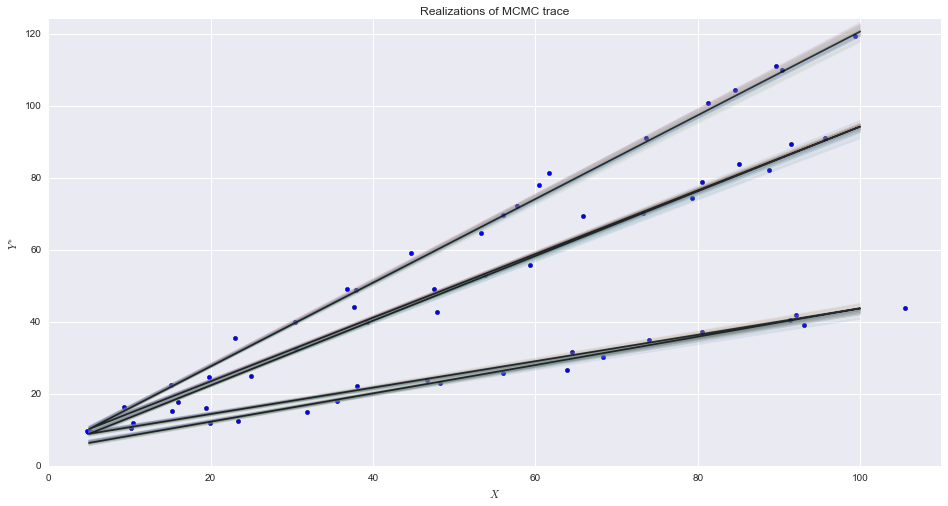

In [15]:
plt.figure(figsize=(16, 8))
plt.hold = 'on'
plt.ylim([0, np.int(obs.y_star.max())+5])
plt.xlim([0, np.int(obs.x.max())+5]);
for i in range(np.int(trace.bias_error.size/2), trace.bias_error.size, np.int(trace.bias_error.size/75)):
    plt.plot(obs.x_star, (1 + trace[i]['gain_error']) * obs.x_star*np.cos(obs.phi +
                                        trace[i]['phase_error']) + trace[i]['bias_error'], alpha=0.1)
plt.plot(obs.x_star, (1 + trace.gain_error.mean()) * obs.x_star*
         np.cos(obs.phi +trace.phase_error.mean()) + trace.bias_error.mean(),
         c='k', alpha=0.75)
plt.scatter(obs.x, obs.y_star)
plt.title('Realizations of MCMC trace')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y^{*}$')

## 3. Naïve Bayesian Model

The Bayesian framework should give an equivalent answer to using a straight frequentist Ordinary Least Squares regression used in packages such as `statsmodels` or `scikit-learn`, but also includes more information in that it does not only give us point estimates, but also distributions around these estimates. This illustrates how (un)likely it considers the true regression parameters  to be. Do they fall within the 95% confidence range, for example?

 [-----------------100%-----------------] 50000 of 50000 complete in 132.3 sec

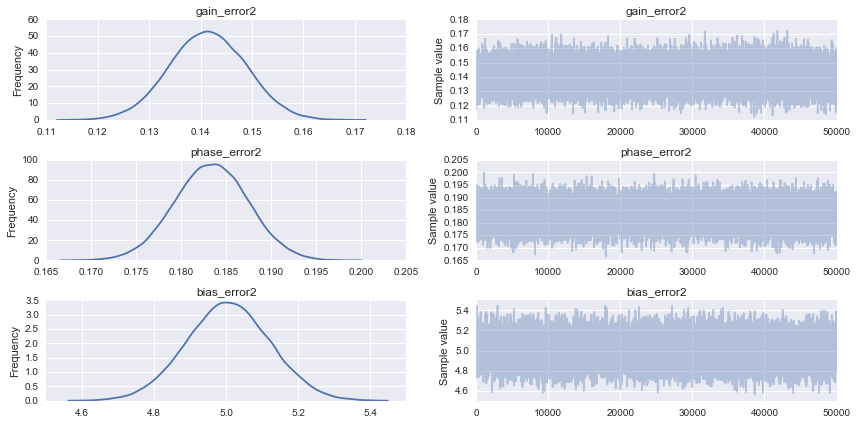

In [16]:
with Model(verbose=0) as model2:

        # Definition of priors
        gain_error2 = Normal('gain_error2', mu=res.x[0], sd=res.x[0]*0.25)
        phase_error2 = Normal('phase_error2', mu=res.x[1], sd=res.x[1]*0.25)
        bias_error2 = Normal('bias_error2', mu=res.x[2], sd=res.x[2]*0.25)
        SD_Y=obs.y_star.as_matrix()*(X_PRECISION/X_CONF**2)
        MU_Y = (1 + gain_error2)*obs.x_star*T.cos(phase_error2 + obs.phi) + bias_error2
        
        y_likelihood2 = Normal('y_est', mu=MU_Y, sd=SD_Y, observed=obs.y_star)
        
        
        #start2 = find_MAP(model=model2, fmin=scipy.optimize.fmin_powell)  
        start2={'gain_error2':res.x[0],'phase_error2':res.x[1],'bias_error2':res.x[2]}                    
        trace_naive = sample(50000, start=start2, step=NUTS())
    
traceplot(trace_naive)
plt.tight_layout();

In [17]:
summary(trace_naive, vars=['gain_error2', 'phase_error2', 'bias_error2'])


gain_error2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.141            0.007            0.000            [0.127, 0.156]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.127          0.136          0.141          0.147          0.156


phase_error2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.183            0.004            0.000            [0.175, 0.191]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.175          0.181          0.183          0.186          0.191


bias_error2:

  Mean             SD               MC Error         95% HPD interval
  ------

We can see although the gain and phase estimates are not far off, even those estimates consider the true values to be less than 1% likely. If it were a frequentist hypothesis test, the true values of the paramaters would be rejected with p<0.05.

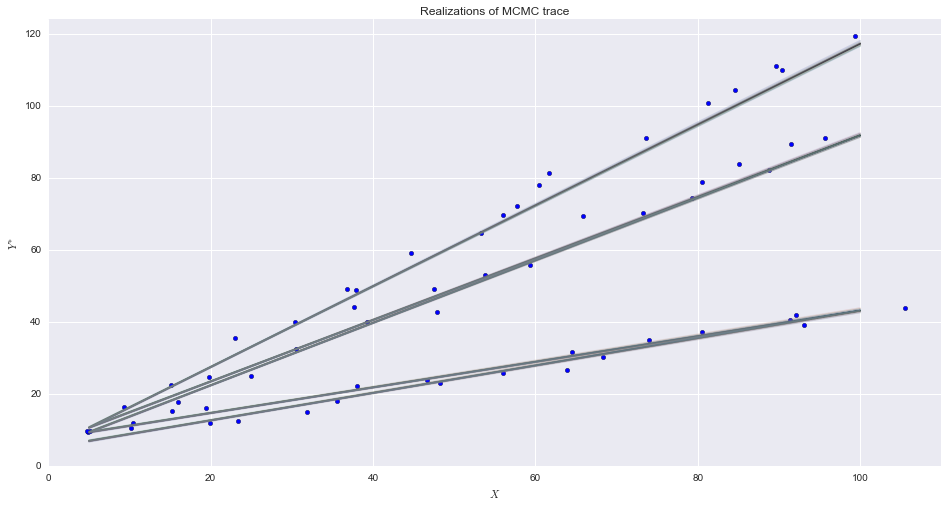

In [18]:
plt.figure(figsize=(16, 8))
plt.hold = 'on'
plt.scatter(obs.x, obs.y_star)

plt.plot(obs.x_star, (1 + trace_naive['gain_error2'].mean()) *
             obs.x_star*np.cos(obs.phi + trace_naive['phase_error2'].mean()) +
             trace_naive['bias_error2'].mean(), c='k')

for i in range(np.int(trace_naive.bias_error2.size/2), trace_naive.bias_error2.size,
               np.int(trace_naive.bias_error2.size/50)):
    plt.plot(obs.x_star, (1 + trace_naive[i]['gain_error2']) *
             obs.x_star*np.cos(obs.phi + trace_naive[i]['phase_error2']) +
             trace_naive[i]['bias_error2'], alpha=0.1)
    plt.ylim([0, np.int(obs.y_star.max())+5])
plt.xlim([0, np.int(obs.x.max())+5]);
plt.title('Realizations of MCMC trace')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y^{*}$')

## Model Comparison

### Case Comparison

The figure below illustrates what the parameter estimates obtained from the different methods above would like like compared to the true line(s):

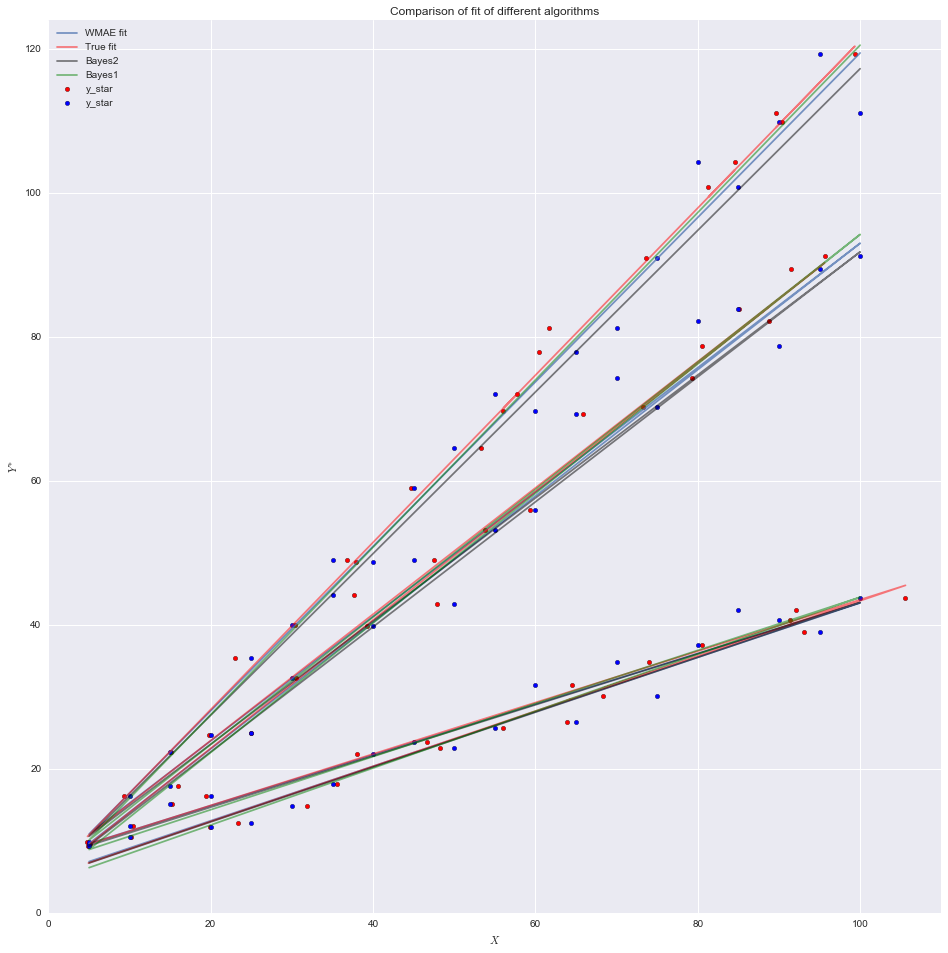

In [19]:
Bayes2 = [trace_naive.gain_error2.mean(),trace_naive.phase_error2.mean(),trace_naive.bias_error2.mean()]

plt.figure(figsize=(16, 16))
plt.hold = 'on'
plt.scatter(obs.x, obs.y_star,c='r')
plt.scatter(obs.x_star, obs.y_star)

plt.plot(obs.x_star, (1 + res.x[0]) * obs.x_star*np.cos(obs.phi + res.x[1]) + res.x[2], alpha=0.75,
        label = 'WMAE fit')
plt.plot(obs.x, (1 + res2.x[0]) * obs.x*np.cos(obs.phi + res2.x[1]) + res2.x[2],c='r',
         label='True fit', alpha=0.5)
plt.plot(obs.x_star, (1 + Bayes2[0]) * obs.x_star*np.cos(obs.phi + Bayes2[1]) + Bayes2[2], c='k',
         alpha=0.5, label='Bayes2')
plt.plot(obs.x_star, (1 + Bayes1[0]) * obs.x_star*
         np.cos(obs.phi +Bayes1[1]) + Bayes1[2],
         c='g',alpha=0.5,label='Bayes1')
#plt.plot(obs.x_star, (1 + (Bayes1[0]+Bayes2[0])/2) *
#             obs.x_star*np.cos(obs.phi + (Bayes1[1]+Bayes2[1])/2) +
#             (Bayes1[2]+Bayes2[2])/2, c='m', alpha=0.5, label='Bayes3')
plt.legend(loc='upper left')
plt.title('Comparison of fit of different algorithms')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y^{*}$')
plt.ylim([0, np.int(obs.y_star.max())+5])
plt.xlim([0, np.int(obs.x.max())+5]);

In [20]:
print('\t gain \tphase\t bias')
print("WMAE:X \t {:.3f}".format(res2.x[0])," {:.3f}".format(res2.x[1])," {:.3f}".format(res2.x[2]))
print("WMAE:X*\t {:.3f}".format(res.x[0])," {:.3f}".format(res.x[1])," {:.3f}".format(res.x[2]))
print("Bayes2 \t {:.3f}".format(Bayes2[0].mean())," {:.3f}".format(Bayes2[1].mean())," {:.3f}".format(Bayes2[2]))
print("Bayes1 \t {:.3f}".format(Bayes1[0])," {:.3f}".format(Bayes1[1])," {:.3f}".format(Bayes1[2]))

	 gain 	phase	 bias
WMAE:X 	 0.183  0.194  5.031
WMAE:X*	 0.163  0.192  5.225
Bayes2 	 0.141  0.183  5.006
Bayes1 	 0.182  0.182  4.292


In [7]:
AbsX_star_err=[(res2.x[0]-res.x[0])/res2.x[0]*100,(res2.x[1]-res.x[1])/res2.x[1]*100,
              (res2.x[2]-res.x[2])/res2.x[2]*100]
Bayes2_err=[(res2.x[0]-Bayes2[0])/res2.x[0]*100,(res2.x[1]-Bayes2[1])/res2.x[1]*100,
           (res2.x[2]-Bayes2[2])/res2.x[2]*100]

print('\t y_gain \t y_phase \t y_bias')
print("WMAE:X*\t {:.3f}".format(AbsX_star_err[0]),"\t{:.3f}".format(AbsX_star_err[1]),"\t\t {:.3f}".format(AbsX_star_err[2]))
print("Bayes1 \t {:.3f}".format(Bayes1_err[0]),"\t\t{:.3f}".format(Bayes1_err[1]),"\t\t {:.3f}".format(Bayes1_err[2]))
print("Bayes2 \t {:.3f}".format(Bayes2_err[0]),"\t{:.3f}".format(Bayes2_err[1]),"\t\t {:.3f}".format(Bayes2_err[2]))

NameError: name 'res2' is not defined

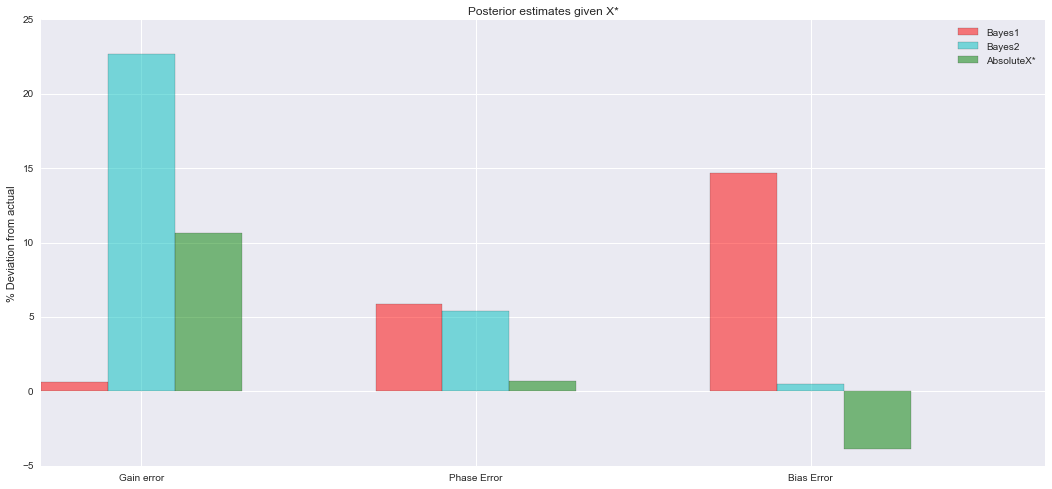

In [22]:
ind = np.arange(3)
width = 0.2

fig,ax = plt.subplots()
rects_B1 = ax.bar(ind,Bayes1_err,width,alpha=0.5,color='r',label='Bayes1')
rects_B2 = ax.bar(ind+width,Bayes2_err,width,alpha=0.5,color='c',label='Bayes2')
rects_A1 = ax.bar(ind+width*2,AbsX_star_err,width,alpha=0.5,color='g',label='AbsoluteX*')
ax.set_ylabel('% Deviation from actual')
ax.set_title('Posterior estimates given X*')
ax.set_xticks(ind+width*1.5)
ax.set_xticklabels(('Gain error','Phase Error','Bias Error'))
ax.legend()

# Overall comparison

The comparisons above are only applicable to this specific case, depending on the random numbers generated. What if a different random seed were used, producing a different dataset?

In order to test the overall performance of the algorithms, I wrote a batch script that would repeat the simulations for different random data sets (random seeds corresponding to the iteration number for repeatability). This script is available in the GitHub repository. Effectively, we are now comparing the performance of the algorithms over multiple data sets; a Monte Carlo of the Monte Carlo. Unfortunately, this is computationally very expensive for my Celeron laptop, and so the data set isn't as large as I would like - only one hundred runs, but enough to identify the pattern. The results are as  follows:

In [12]:
results = pd.read_csv('results.csv',index_col=0)
np.round(results.describe([0.025,0.5,0.975]),2)

,X* gain,X* phase,X* bias,Bayes1 gain,Bayes1 phase,Bayes1 bias,Bayes2 gain,Bayes2 phase,Bayes2 bias,OLS_gain,OLS_phase,OLS_bias
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.41,0.43,1.49,-0.26,1.49,3.22,-11.66,1.70,23.74,-1.49,-2.45,-14.22
std,15.90,10.63,12.32,16.45,10.16,19.40,28.27,11.24,35.72,21.47,13.53,59.31
min,-41.55,-25.67,-38.18,-52.45,-31.97,-86.55,-119.78,-30.89,-94.27,-73.15,-48.84,-452.11
2.5%,-23.86,-20.94,-16.10,-28.62,-18.49,-36.70,-73.44,-20.55,-17.37,-52.61,-34.35,-108.12
50%,1.04,1.19,0.58,-0.31,1.05,1.88,-4.94,1.72,17.93,1.74,-0.46,-3.85
97.5%,27.27,18.46,39.30,28.71,20.70,51.35,27.94,24.49,100.62,29.38,18.74,44.37
max,55.21,39.14,44.57,34.70,39.52,62.92,31.25,33.09,222.81,42.77,21.24,60.81


## Gain Error

This is the 'slope' term of the equation, and we can see that the Bayesian method estimates the parameters with smaller errors and smaller variance in the errors than the other methods.

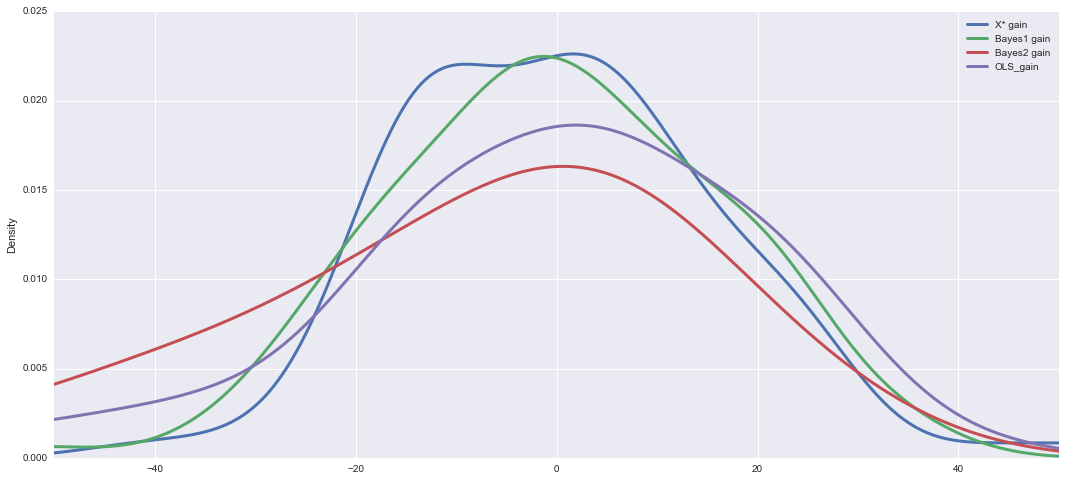

In [35]:
results[['X* gain','Bayes1 gain','Bayes2 gain','OLS_gain']].plot(kind='kde', xlim=[-50,50], lw=3.0)

## Phase Error

This is the non-linear term. Once again, the Bayesian method has a lower variance, although the mode of the distribution seems slightly further off zero than the WMAE method, although the Bayesian mean is closer to zero.

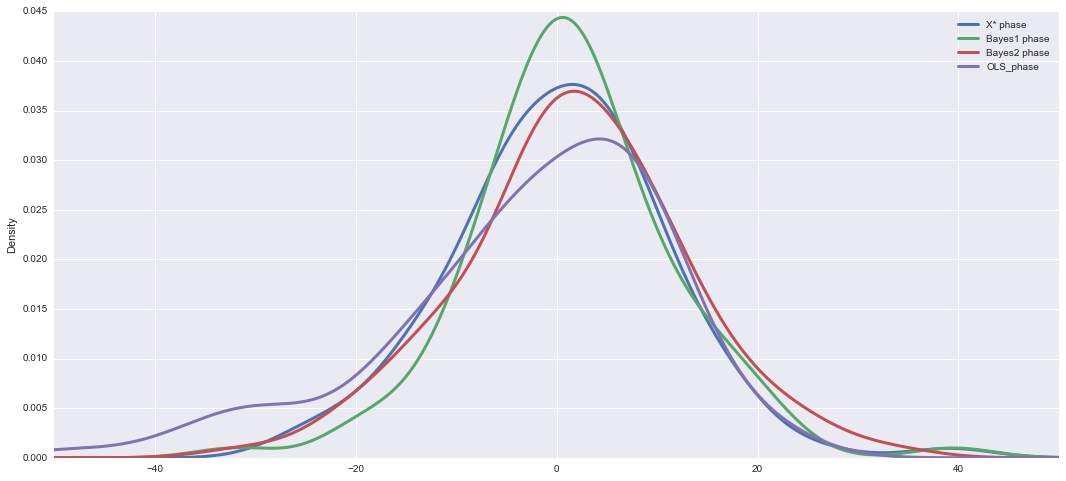

In [25]:
results[['X* phase','Bayes1 phase','Bayes2 phase','OLS_phase']].plot(kind='kde', xlim=[-50,50], lw=3.0)

## Bias Error

We can see that for the bias (intercept) error, the WMAE does give a more accurate estimate than the Bayesian method. The question now arises, should we use the $\hat{\phi}_{WMAE}$ instead of $\hat{\phi}_{Bayesian}$? And the answer isn't a simple 'yes'. We should consider the interaction between the parameters. The other Bayesian parameters for a specific data set have been selected for a best fit with the 'erroneous' bias parameter estimate. Using a different estimate whilst keeping the other parameters the same may lead to a deterioration in the goodness of the overall fit, even if the errors on all the parameters are now smaller.

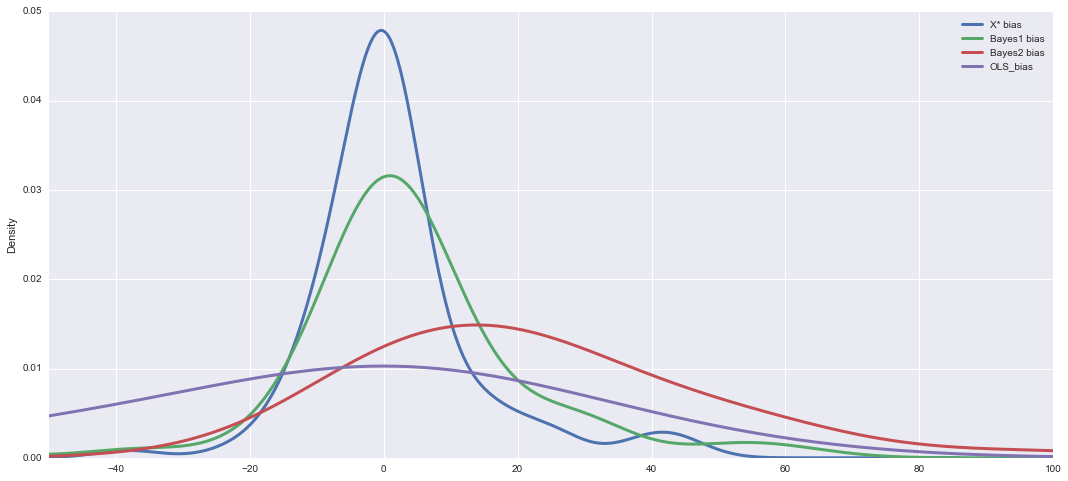

In [33]:
results[['X* bias','Bayes1 bias','Bayes2 bias','OLS_bias']].plot(kind='kde', xlim=[-50,100], lw=3.0)

# Conclusion

We can see that measurement errors, especially errors in $X$, pose a serious problem when doing regression. For the case of electrical energy measurement calibration, the specifics of the error generation process can be used to our advantage, though.

The effect of measurement error can be minimised relatively effectively and quickly by using a Weighted Minimum Absolute Error (WMAE) optimization function. However, Bayesian models provide a more computationally expensive, but more accurate and comprehensive alternative estimate. In the end, the effect of measurement uncertainty on the parameter estimates can be mitigated to within a few percent of the true parameter values, eliminating attenuation bias almost completely.